# Background

The shape of outputs in integrated gradients suggests that IG may overestimate some attribution values due to saturated gradients at interpolated inputs. To confirm this, we run SplitIG (which cuts off the interpolated inputs if the gradients are saturated) and examine the level of agreement.

In [1]:
%load_ext autoreload
%autoreload 2

In [51]:
import torch
import pandas as pd
import numpy as np

from functools import partial
from typing import Optional

from transformer_lens.utils import get_act_name, get_device
from transformer_lens import ActivationCache, HookedTransformer, HookedTransformerConfig
from transformer_lens.hook_points import HookPoint

import seaborn as sns
import matplotlib.pyplot as plt

from utils import Task, TaskDataset, logit_diff_metric, run_from_layer_fn, plot_attn_comparison, plot_correlation
from split_ig import SplitLayerIntegratedGradients

from captum.attr import LayerIntegratedGradients
from attribution_methods import compute_layer_to_output_attributions

In [3]:
torch.set_grad_enabled(False)

device = get_device()
# device = torch.device("cpu")
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

# Explicitly calculate and expose the result for each attention head
model.set_use_attn_result(True)
model.set_use_hook_mlp_in(True)

Loaded pretrained model gpt2-small into HookedTransformer


## Set up Split IG

In [47]:
def compute_layer_to_output_attributions_split_ig(
    original_input, 
    layer_input, 
    layer_baseline, 
    target_layer, 
    prev_layer, 
    metric, 
    metric_labels, 
    ratio=1.0,
):
    n_steps = 50
    n_samples = original_input.size(0)

    # Take the model starting from the target layer
    forward_fn = lambda x: run_from_layer_fn(model, original_input, prev_layer, x, metric, metric_labels)

    # Attribute to the target_layer's output
    split_ig = SplitLayerIntegratedGradients(forward_fn, target_layer, multiply_by_inputs=True)
    attributions = split_ig.attribute(inputs=layer_input,
                                    baselines=layer_baseline,
                                    n_steps=n_steps,
                                    internal_batch_size=n_samples, # Needs to match patching shape
                                    attribute_to_layer_input=False,
                                    return_convergence_delta=False)
    grads, outputs, _, _ = attributions

    # [n_samples, n_steps, seq_len, d_heads, d_model]
    grads = grads.reshape((-1, n_steps,) + grads.shape[1:])
    # [n_samples, n_steps]
    outputs = outputs.reshape((-1, n_steps))

    # Sanity check: shape of output
    # plt.plot(outputs[0].detach().cpu())
    # plt.show()

    left_igs = torch.zeros((n_samples,) + grads.shape[2:])
    right_igs = torch.zeros((n_samples,)+ grads.shape[2:])
    threshold_indices = torch.zeros((n_samples,))

    for i in range(n_samples):
        sample_output = outputs[i] # Shape [n_steps]
        sample_grads = grads[i]

        # Calculate threshold for split integrated gradients
        min_out, min_index = torch.min(sample_output, dim=0)
        max_out, max_index = torch.max(sample_output, dim=0)
        # Take output values up until threshold
        threshold = min_out + ratio * (max_out - min_out)

        if ratio == 1:
            assert torch.isclose(threshold, max_out), f"Threshold {threshold} is not equal to maximum {max_out} at {max_index}, when minimum is {min_out} at {min_index}"

        if max_index < min_index:
            # Flip direction such that min_index < max_index
            sample_output = sample_output.flip(dims=(0,))
            sample_grads = sample_grads.flip(dims=(0,))

        mask = sample_output > threshold + 1e-5 # Handle float precision errors
        if torch.count_nonzero(mask) > 0:
            print(f"There are outputs above the threshold {threshold}. {mask}")
            threshold_index = mask.int().argmax(dim=0)
            print(f"Value at threshold index: {sample_output[threshold_index]}")
            if max_index < min_index:
                threshold_indices[i] = n_steps - threshold_index
            else:
                threshold_indices[i] = threshold_index
        else:
            # No value is above threshold, take full IG
            threshold_index = n_steps
            threshold_indices[i] = threshold_index

        if ratio == 1:
            assert threshold_indices[i] == n_steps, f"Threshold index is {threshold_indices[i]}, expected {n_steps}."

        # Grads have already been scaled and multiplied.
        left_igs[i] = sample_grads[i, :threshold_index].sum(dim=0)
        right_igs[i] = sample_grads[i, threshold_index:].sum(dim=0)

    return left_igs, right_igs, threshold_indices

In [6]:
def split_integrated_gradients(model: HookedTransformer, clean_tokens: torch.Tensor, clean_cache: ActivationCache, corrupted_cache: ActivationCache, metric: callable, metric_labels, ratio: float):
    n_samples = clean_tokens.size(0)
    
    # Gradient attribution for neurons in MLP layers
    mlp_results = torch.zeros(n_samples, model.cfg.n_layers, model.cfg.d_mlp)
    # Gradient attribution for attention heads
    attn_results = torch.zeros(n_samples, model.cfg.n_layers, model.cfg.n_heads)

    # Calculate integrated gradients for each layer
    for layer in range(model.cfg.n_layers):

        # Gradient attribution on heads
        hook_name = get_act_name("result", layer)
        target_layer = model.hook_dict[hook_name]
        prev_layer_hook = get_act_name("z", layer)
        prev_layer = model.hook_dict[prev_layer_hook]

        layer_clean_input = clean_cache[prev_layer_hook]
        layer_corrupt_input = corrupted_cache[prev_layer_hook]

        # Shape [batch, seq_len, d_head, d_model]
        left_ig, right_ig, _ = compute_layer_to_output_attributions_split_ig(
            clean_tokens, layer_corrupt_input, layer_clean_input, target_layer, prev_layer, metric, metric_labels, ratio)

        # Calculate attribution score based on mean over each embedding, for each token
        per_token_score = left_ig.mean(dim=3)
        score = per_token_score.mean(dim=1)
        attn_results[:, layer] = score

        # Gradient attribution on MLP neurons
        hook_name = get_act_name("post", layer)
        target_layer = model.hook_dict[hook_name]
        prev_layer_hook = get_act_name("mlp_in", layer)
        prev_layer = model.hook_dict[prev_layer_hook]

        layer_clean_input = clean_cache[prev_layer_hook]
        layer_corrupt_input = corrupted_cache[prev_layer_hook]
        
        # Shape [batch, seq_len, d_model]
        left_ig, right_ig, _ = compute_layer_to_output_attributions_split_ig(
            clean_tokens, layer_corrupt_input, layer_clean_input, target_layer, prev_layer, metric, metric_labels, ratio)
        score = left_ig.mean(dim=1)
        mlp_results[:, layer] = score

    return mlp_results, attn_results

# Split IG and IOI

In [62]:
ioi_dataset = TaskDataset(Task.IOI)
ioi_dataloader = ioi_dataset.to_dataloader(batch_size=1)

In [63]:
clean_input, corrupted_input, labels = next(iter(ioi_dataloader))

clean_tokens = model.to_tokens(clean_input)
corrupted_tokens = model.to_tokens(corrupted_input)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = logit_diff_metric(clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = logit_diff_metric(corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

Clean logit difference: tensor([2.3827], device='cuda:0')
Corrupted logit difference: tensor([-2.3610], device='cuda:0')


## Sanity check: no splitting

In [64]:
# Check that attention head attributions are the same for random head

hook_name = get_act_name("result", 5)
target_layer = model.hook_dict[hook_name]
prev_layer_hook = get_act_name("z", 5)
prev_layer = model.hook_dict[prev_layer_hook]

layer_clean_input = clean_cache[prev_layer_hook]
layer_corrupt_input = corrupted_cache[prev_layer_hook]

# Shape [batch, seq_len, d_head, d_model]
left_ig, _, _ = compute_layer_to_output_attributions_split_ig(
    clean_tokens, layer_corrupt_input, layer_clean_input, target_layer, prev_layer, logit_diff_metric, labels, ratio=1)

original_attributions = compute_layer_to_output_attributions(
    model, clean_tokens, layer_corrupt_input, layer_clean_input, target_layer, prev_layer, logit_diff_metric, labels
)


Error (delta) for blocks.5.attn.hook_result attribution: tensor([2.7418e-06], device='cuda:0')


In [65]:
print(left_ig[:, :, 5])
print(original_attributions[:, :, 5])

torch.allclose(left_ig, original_attributions.detach().cpu())

tensor([[[-6.0832e-05,  1.6098e-07, -6.0377e-06,  ...,  1.3591e-06,
          -1.5692e-06, -1.0852e-05],
         [-6.0832e-05,  1.6098e-07, -6.0377e-06,  ...,  1.3591e-06,
          -1.5692e-06, -1.0852e-05],
         [-6.0832e-05,  1.6098e-07, -6.0377e-06,  ...,  1.3591e-06,
          -1.5692e-06, -1.0852e-05],
         ...,
         [-6.0832e-05,  1.6098e-07, -6.0377e-06,  ...,  1.3591e-06,
          -1.5692e-06, -1.0852e-05],
         [-6.0832e-05,  1.6098e-07, -6.0377e-06,  ...,  1.3591e-06,
          -1.5692e-06, -1.0852e-05],
         [-6.0832e-05,  1.6098e-07, -6.0377e-06,  ...,  1.3591e-06,
          -1.5692e-06, -1.0852e-05]]])
tensor([[[-0.0000e+00, -0.0000e+00, -0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00, -0.0000e+00],
         [-0.0000e+00, -0.0000e+00, -0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00, -0.0000e+00],
         [-0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         ...,
         [-9.8267e-06, -1

False

In [70]:
n_samples = clean_tokens.size(0)
forward_fn = lambda x: run_from_layer_fn(model, clean_tokens, prev_layer, x, logit_diff_metric, labels)

split_ig = SplitLayerIntegratedGradients(forward_fn, target_layer, multiply_by_inputs=True)
split_ig_attributions, _, _, _ = split_ig.attribute(inputs=layer_corrupt_input,
                                baselines=layer_clean_input,
                                internal_batch_size=n_samples, # Needs to match patching shape
                                attribute_to_layer_input=False,
                                return_convergence_delta=False)
split_ig_attributions = split_ig_attributions.reshape((-1, 50,) + split_ig_attributions.shape[1:])
split_ig_attributions = split_ig_attributions.sum(dim=1)

ig_embed = LayerIntegratedGradients(forward_fn, target_layer, multiply_by_inputs=True)
ig_attributions = ig_embed.attribute(inputs=layer_corrupt_input,
                                baselines=layer_clean_input, 
                                internal_batch_size=n_samples,
                                attribute_to_layer_input=False,
                                return_convergence_delta=False)

In [71]:
print(split_ig_attributions.shape)
print(ig_attributions.shape)

print(split_ig_attributions[0, :, 5])
print(ig_attributions[0, :, 5])

torch.allclose(split_ig_attributions, ig_attributions)

torch.Size([1, 18, 12, 768])
torch.Size([1, 18, 12, 768])
tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [-9.8267e-06, -1.1791e-05, -1.2999e-07,  ...,  2.0430e-06,
         -7.0533e-07, -2.7675e-06],
        [ 3.1355e-06,  3.5845e-07,  6.6304e-06,  ..., -5.2538e-09,
         -4.7680e-06, -2.3545e-06],
        [ 3.6521e-10, -1.2898e-05,  9.4153e-06,  ..., -2.0631e-06,
          6.4367e-06,  1.5743e-05]], device='cuda:0')
tensor([[-0.0000e+00, -0.0000e+00, -0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00, -0.0000e+00],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00, -0.0000e+00],
        [-0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00

True

In [35]:
ioi_split_ig_mlp, ioi_split_ig_attn = split_integrated_gradients(model, clean_tokens, clean_cache, corrupted_cache, logit_diff_metric, labels, ratio=1)

In [24]:
original_ioi_ig_mlp = torch.load("saved_results/ioi_ig_mlp.pt")
original_ioi_ig_attn = torch.load("saved_results/ioi_ig_attn.pt")

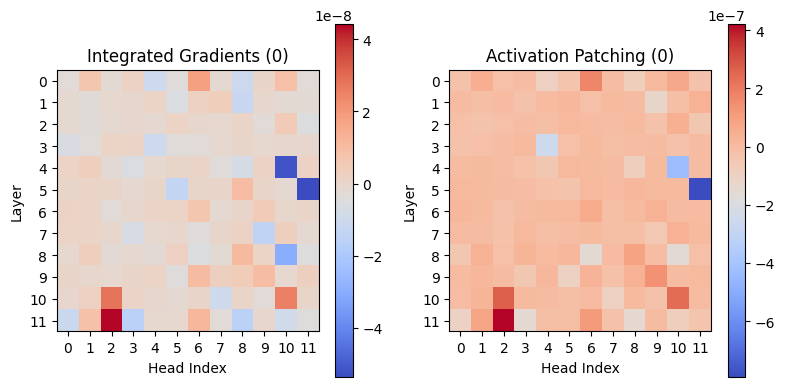

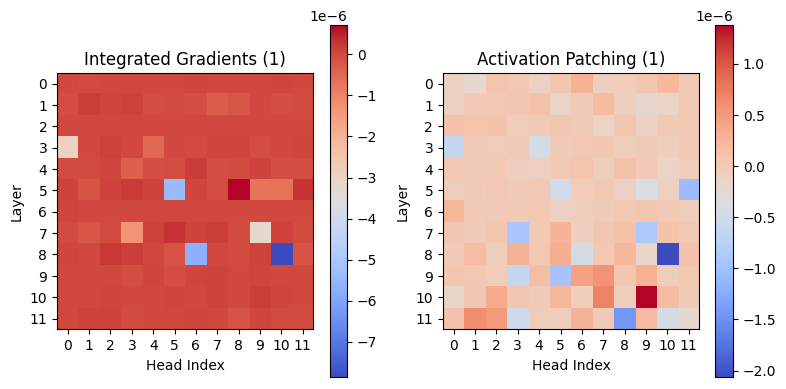

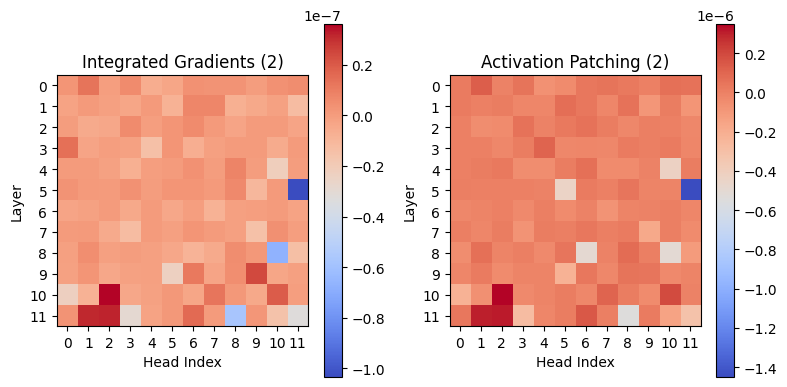

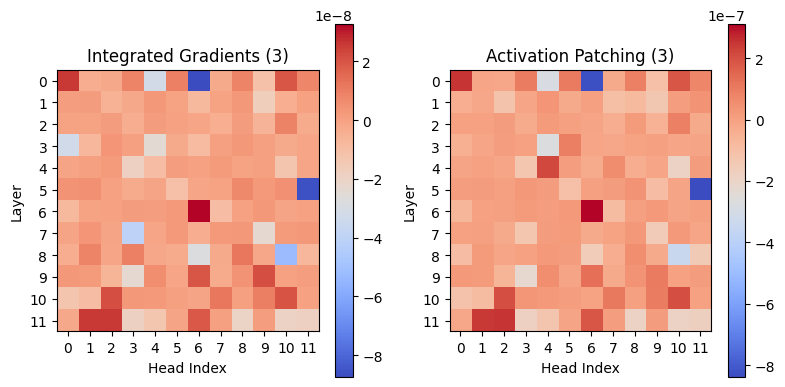

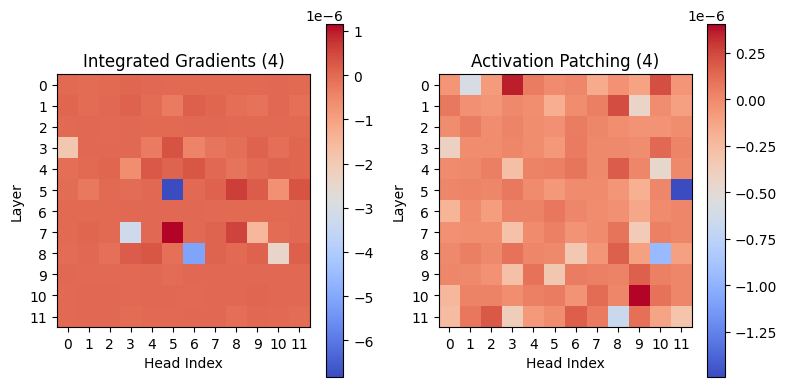

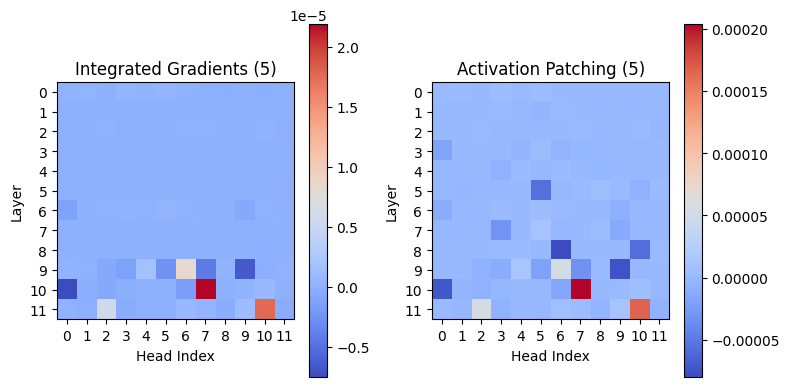

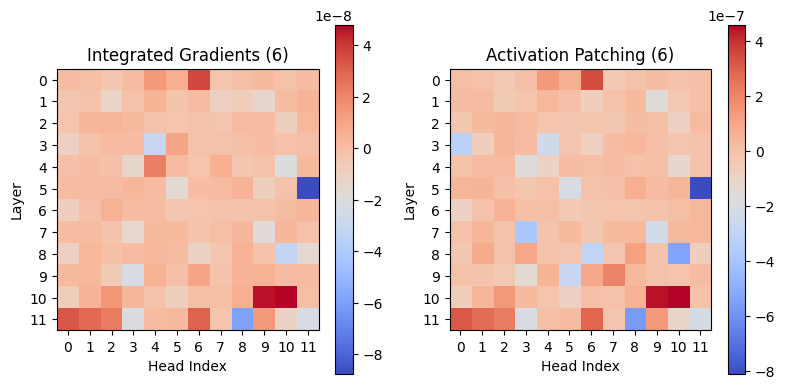

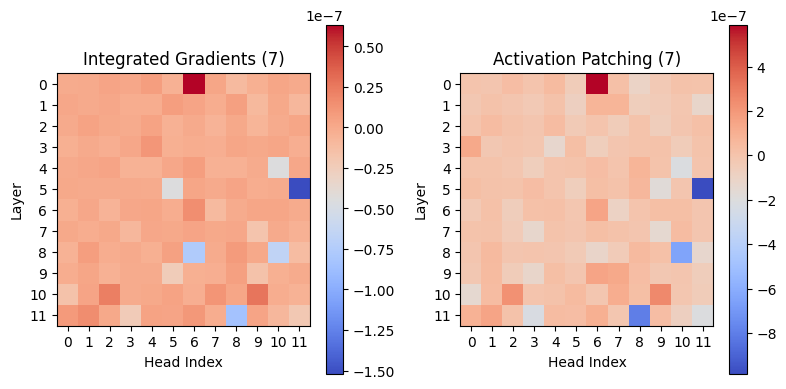

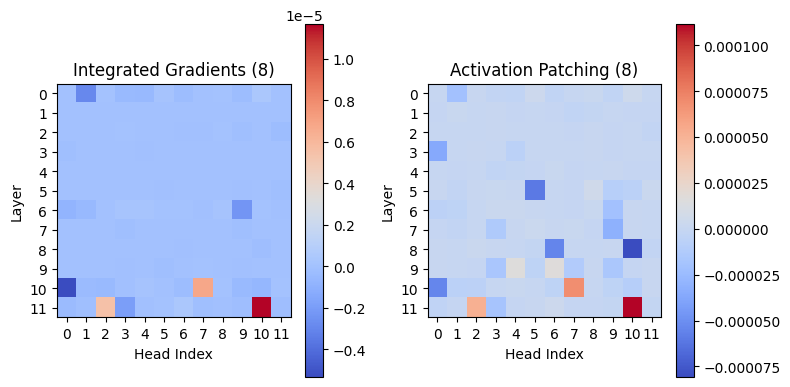

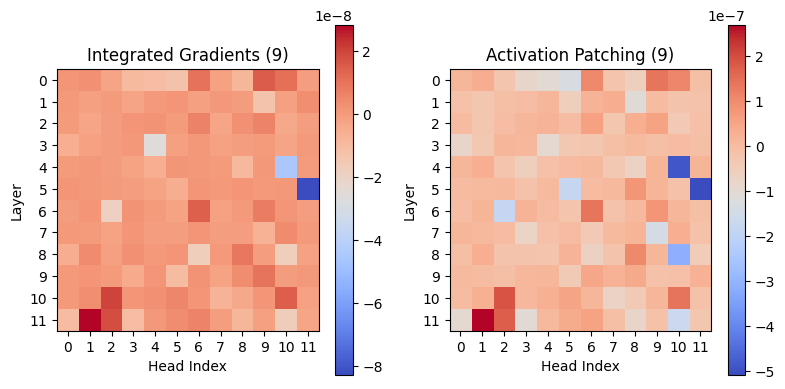

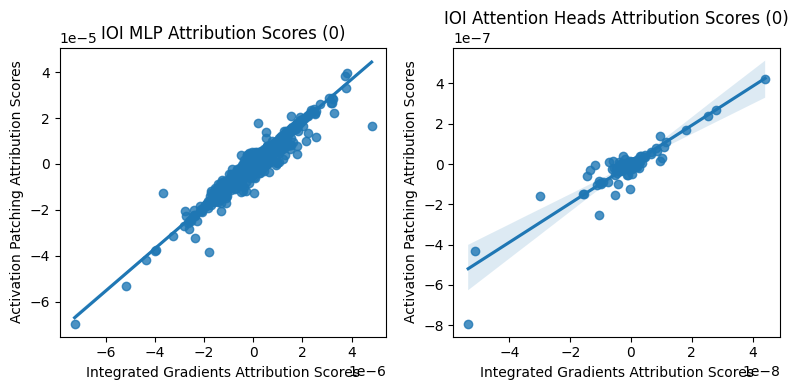

Correlation coefficient for neurons: 0.9800047069580933
Correlation coefficient for attention heads: 0.9145957602553948


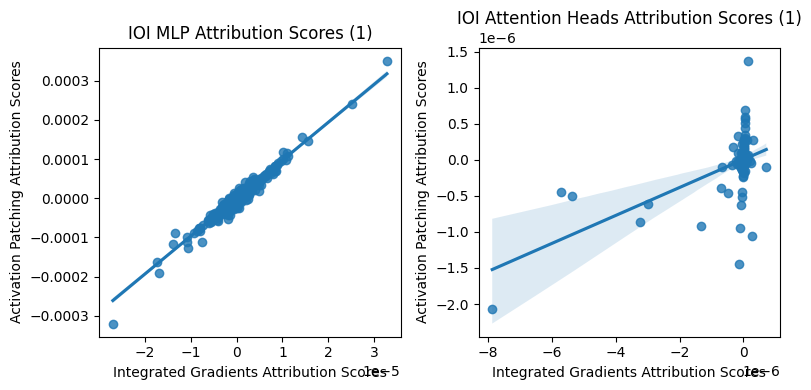

Correlation coefficient for neurons: 0.9845055845133378
Correlation coefficient for attention heads: 0.5622830250906731


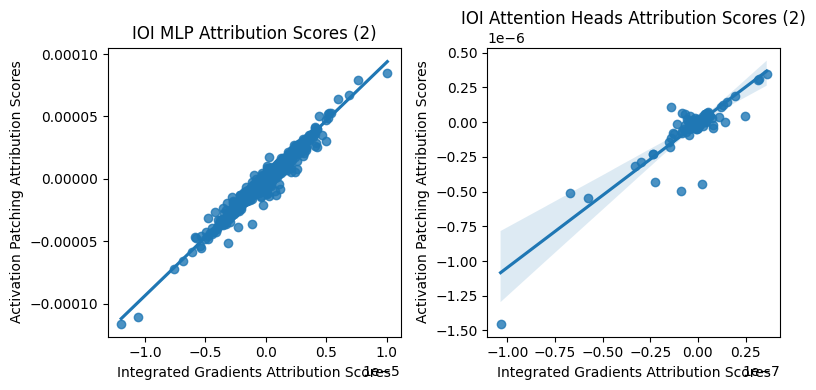

Correlation coefficient for neurons: 0.9884381360238422
Correlation coefficient for attention heads: 0.8858925051869404


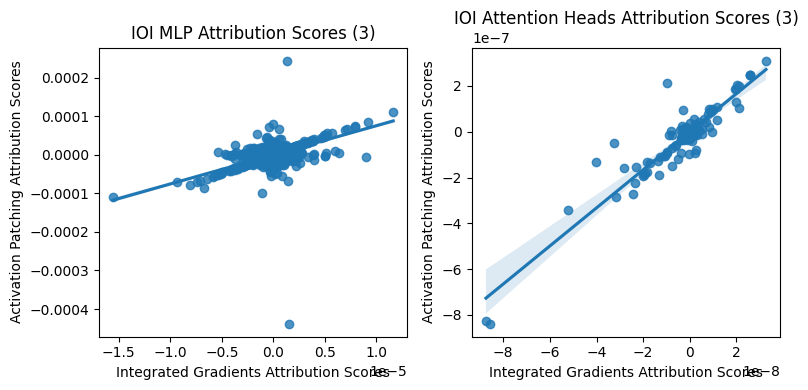

Correlation coefficient for neurons: 0.6511273622485128
Correlation coefficient for attention heads: 0.9291702738681874


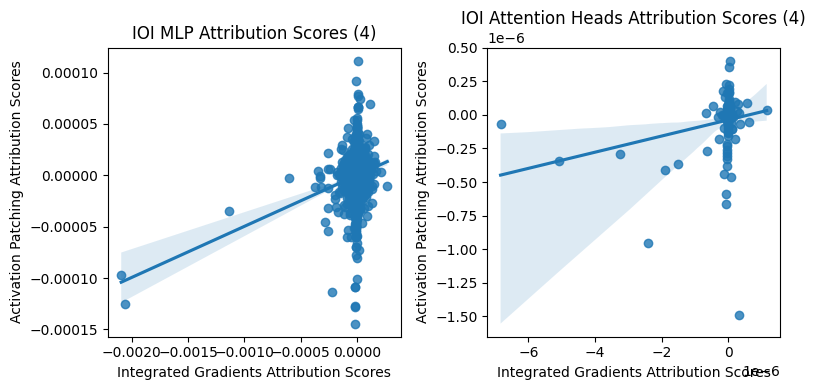

Correlation coefficient for neurons: 0.17238541272071328
Correlation coefficient for attention heads: 0.23861052112343725


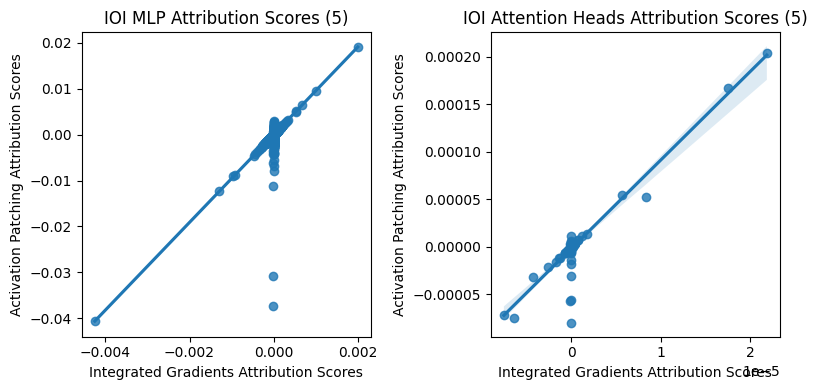

Correlation coefficient for neurons: 0.721272724855344
Correlation coefficient for attention heads: 0.9255984254636241


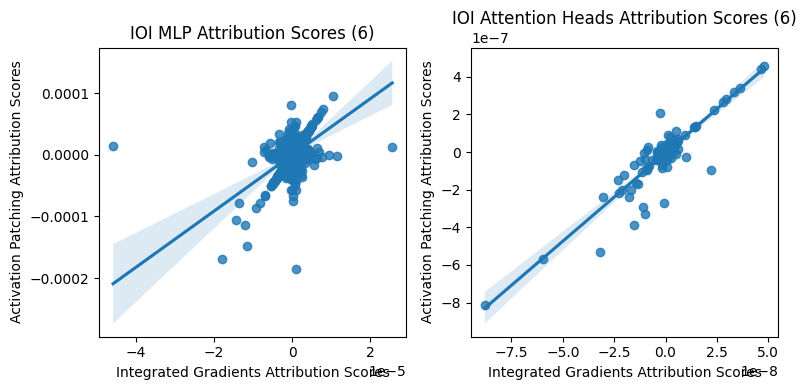

Correlation coefficient for neurons: 0.5567518181132752
Correlation coefficient for attention heads: 0.904235717503441


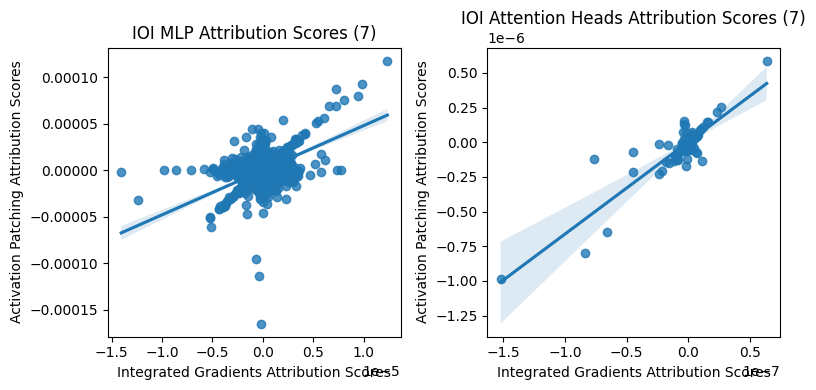

Correlation coefficient for neurons: 0.5401367909827296
Correlation coefficient for attention heads: 0.8834199951950487


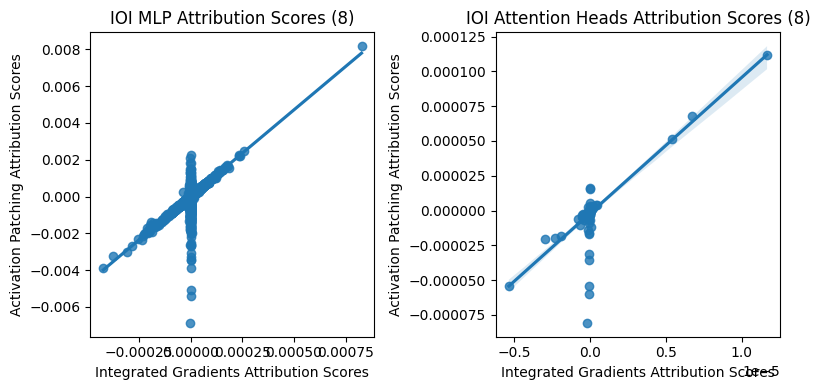

Correlation coefficient for neurons: 0.7338450526150303
Correlation coefficient for attention heads: 0.7807446490336345


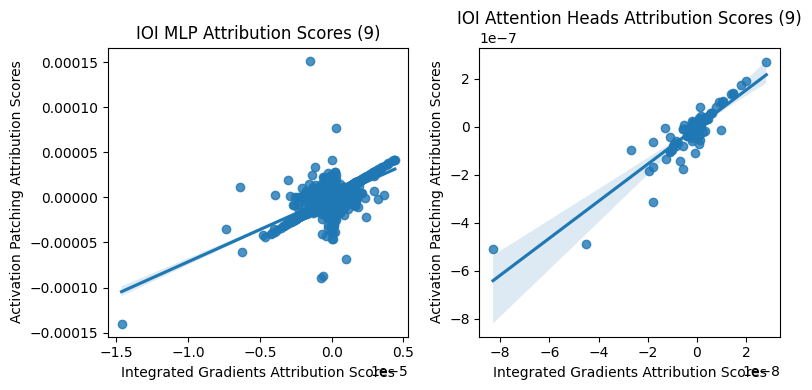

Correlation coefficient for neurons: 0.6682051389545179
Correlation coefficient for attention heads: 0.9032780345298375


In [36]:
plot_attn_comparison(ioi_split_ig_attn, original_ioi_ig_attn, Task.IOI, model)
plot_correlation(ioi_split_ig_mlp, original_ioi_ig_mlp, ioi_split_ig_attn, original_ioi_ig_attn, Task.IOI)

## Split at 0.95 ratio

In [ ]:
ioi_ap_mlp = torch.load("saved_results/ioi_ap_mlp.pt")
ioi_ap_attn = torch.load("saved_results/ioi_ap_attn.pt")

In [ ]:
ioi_split_ig_mlp = torch.load("saved_results/ioi_split_ig_mlp.pt")
ioi_split_ig_attn = torch.load("saved_results/ioi_split_ig_attn.pt")

SyntaxError: invalid syntax (4235631849.py, line 2)

In [101]:
ioi_split_ig_mlp, ioi_split_ig_attn = split_integrated_gradients(model, clean_tokens, clean_cache, corrupted_cache, logit_diff_metric, labels, ratio=0.95)

torch.save(ioi_split_ig_mlp, "saved_results/ioi_split_ig_mlp.pt")
torch.save(ioi_split_ig_attn, "saved_results/ioi_split_ig_attn.pt")

torch.Size([10, 200, 21, 12, 768]) torch.Size([10, 200])
torch.Size([200]) torch.Size([200, 21, 12, 768])
torch.Size([200]) torch.Size([200, 21, 12, 768])
torch.Size([200]) torch.Size([200, 21, 12, 768])
torch.Size([200]) torch.Size([200, 21, 12, 768])
torch.Size([200]) torch.Size([200, 21, 12, 768])
torch.Size([200]) torch.Size([200, 21, 12, 768])
torch.Size([200]) torch.Size([200, 21, 12, 768])
torch.Size([200]) torch.Size([200, 21, 12, 768])
torch.Size([200]) torch.Size([200, 21, 12, 768])
torch.Size([200]) torch.Size([200, 21, 12, 768])
torch.Size([10, 200, 21, 3072]) torch.Size([10, 200])
torch.Size([200]) torch.Size([200, 21, 3072])
torch.Size([200]) torch.Size([200, 21, 3072])
torch.Size([200]) torch.Size([200, 21, 3072])
torch.Size([200]) torch.Size([200, 21, 3072])
torch.Size([200]) torch.Size([200, 21, 3072])
torch.Size([200]) torch.Size([200, 21, 3072])
torch.Size([200]) torch.Size([200, 21, 3072])
torch.Size([200]) torch.Size([200, 21, 3072])
torch.Size([200]) torch.Size([2

KeyboardInterrupt: 

In [ ]:
plot_attn_comparison(ioi_split_ig_attn, ioi_ap_attn, Task.IOI, model)
plot_correlation(ioi_split_ig_mlp, ioi_ap_mlp, ioi_split_ig_attn, ioi_ap_attn, Task.IOI)